In [2]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [3]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


### 2. Set key parameters

In [4]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [5]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

58892288/58889256 [==============================] - 28s 0us/step


In [6]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(input = model.input, output = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [9]:
### Start training!

history_object = model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=15, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=11, validation_steps=164)`
  if __name__ == '__main__':


Epoch 1/15
11/11 [==============================] - 169s 15s/step - loss: 0.4477 - accuracy: 0.7507 - val_loss: 0.3583 - val_accuracy: 0.7683
Epoch 2/15
11/11 [==============================] - 197s 18s/step - loss: 0.3439 - accuracy: 0.8195 - val_loss: 0.2379 - val_accuracy: 0.8869
Epoch 3/15
11/11 [==============================] - 163s 15s/step - loss: 0.2626 - accuracy: 0.9398 - val_loss: 0.1570 - val_accuracy: 0.9088
Epoch 4/15
11/11 [==============================] - 166s 15s/step - loss: 0.1928 - accuracy: 0.9628 - val_loss: 0.1823 - val_accuracy: 0.9145
Epoch 5/15
11/11 [==============================] - 160s 15s/step - loss: 0.1554 - accuracy: 0.9545 - val_loss: 0.1124 - val_accuracy: 0.9285
Epoch 6/15
11/11 [==============================] - 155s 14s/step - loss: 0.1149 - accuracy: 0.9685 - val_loss: 0.7996 - val_accuracy: 0.9245
Epoch 7/15
11/11 [==============================] - 160s 15s/step - loss: 0.1359 - accuracy: 0.9656 - val_loss: 0.2065 - val_accuracy: 0.9325
Epoch 

In [11]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


KeyError: 'acc'

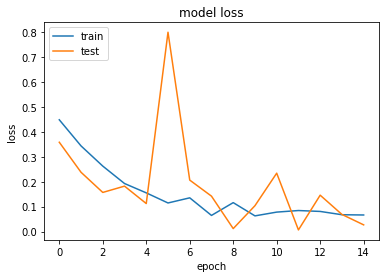

In [12]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()